In [1]:
import numpy as np
import pandas as pd
import warnings
import os

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Flatten
from tensorflow.compat.v1.keras.layers import TimeDistributed

warnings.simplefilter('ignore')

countryName = 'US'

nFeatures = 1

nDaysMin = 3
k = 3

nValid = 10
nTest = 10

In [2]:
dataDir = os.path.join('C:\\Users\\AMC\\Desktop\\Roshi\\Data')
confirmedFilename = 'confirmed_july.csv'
deathsFilename = 'deaths_july.csv'
recoveredFilename = 'recovered_july.csv'

In [3]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps, k):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix + k >= len(sequence):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:end_ix+k]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [4]:
def meanAbsolutePercentageError(yTrueList, yPredList):
    absErrorList = [np.abs(yTrue - yPred) for yTrue, yPred in zip(yTrueList, yPredList)]
    absPcErrorList = [absError/yTrue for absError, yTrue in zip(absErrorList, yTrueList)]
    MAPE = 100*np.mean(absPcErrorList)
    return MAPE

def meanAbsolutePercentageError_kDay(yTrueListList, yPredListList):
    # Store true and predictions for day 1 in a list, day 2 in a list and so on
    # Keep each list of these lists in a respective dict with key as day #
    yTrueForDayK = {}
    yPredForDayK = {}
    for i in range(len(yTrueListList[0])):
        yTrueForDayK[i] = []
        yPredForDayK[i] = []
    for yTrueList, yPredList in zip(yTrueListList, yPredListList):
        for i in range(len(yTrueList)):
            yTrueForDayK[i].append(yTrueList[i])
            yPredForDayK[i].append(yPredList[i])
            
    # Get MAPE for each day in a list
    MAPEList = []
    for i in yTrueForDayK.keys():
        MAPEList.append(meanAbsolutePercentageError(yTrueForDayK[i], yPredForDayK[i]))
    return np.mean(MAPEList)

def meanForecastError(yTrueList, yPredList):
    forecastErrors = [yTrue - yPred for yTrue, yPred in zip(yTrueList, yPredList)]
    MFE = np.mean(forecastErrors)
    return MFE

def meanAbsoluteError(yTrueList, yPredList):
    absErrorList = [np.abs(yTrue - yPred) for yTrue, yPred in zip(yTrueList, yPredList)]
    return np.mean(absErrorList)

def meanSquaredError(yTrueList, yPredList):
    sqErrorList = [np.square(yTrue - yPred) for yTrue, yPred in zip(yTrueList, yPredList)]
    return np.mean(sqErrorList)

def rootMeanSquaredError(yTrueList, yPredList):
    return np.sqrt(meanSquaredError(yTrueList, yPredList))
def medianSymmetricAccuracy(yTrueList, yPredList):
    '''https://helda.helsinki.fi//bitstream/handle/10138/312261/2017SW001669.pdf?sequence=1'''
    logAccRatioList = [np.abs(np.log(yPred/yTrue)) for yTrue, yPred in zip(yTrueList, yPredList)]
    MdSA = 100*(np.exp(np.median(logAccRatioList))-1)
    return MdSA

def medianSymmetricAccuracy_kDay(yTrueListList, yPredListList):
    # Store true and predictions for day 1 in a list, day 2 in a list and so on
    # Keep each list of these lists in a respective dict with key as day #
    yTrueForDayK = {}
    yPredForDayK = {}
    for i in range(len(yTrueListList[0])):
        yTrueForDayK[i] = []
        yPredForDayK[i] = []
    for yTrueList, yPredList in zip(yTrueListList, yPredListList):
        for i in range(len(yTrueList)):
            yTrueForDayK[i].append(yTrueList[i])
            yPredForDayK[i].append(yPredList[i])
    # Get MdSA for each day in a list
    MdSAList = []
    for i in yTrueForDayK.keys():
        MdSAList.append(medianSymmetricAccuracy(yTrueForDayK[i], yPredForDayK[i]))
    return(np.mean(MdSAList))

In [5]:
# Function to get all three frames for a given country
def getCountryCovidFrDict(countryName):
    countryCovidFrDict = {}
    for key in covidFrDict.keys():
        dataFr = covidFrDict[key]
        countryCovidFrDict[key] = dataFr[dataFr['Country/Region'] == countryName]
    return countryCovidFrDict

In [6]:
# Load all 3 csv files
covidFrDict = {}
covidFrDict['confirmed'] = pd.read_csv(confirmedFilename)
covidFrDict['deaths'] = pd.read_csv(deathsFilename)
covidFrDict['recovered'] = pd.read_csv(recoveredFilename)

countryCovidFrDict = getCountryCovidFrDict(countryName)

# date list
colNamesList = list(countryCovidFrDict['confirmed'])
dateList = [colName for colName in colNamesList if '/20' in colName]
dataList = [countryCovidFrDict['confirmed'][date].iloc[0] for date in dateList]
dataDict = dict(zip(dateList, dataList))

# Only take time series from where the cases were >100
daysSince = 100
nCasesGreaterDaysSinceList = []
datesGreaterDaysSinceList = []

for key in dataDict.keys():
    if dataDict[key] > daysSince:
        datesGreaterDaysSinceList.append(key)
        nCasesGreaterDaysSinceList.append(dataDict[key])
        
XList, yList = split_sequence(nCasesGreaterDaysSinceList, nDaysMin, k)

XTrainList = XList[0:len(XList)-(nValid + nTest)]
XValidList = XList[len(XList)-(nValid+nTest):len(XList)-(nTest)]
XTestList = XList[-nTest:]

yTrain = yList[0:len(XList)-(nValid + nTest)]
yValid = yList[len(XList)-(nValid+nTest):len(XList)-(nTest)]
yTest = yList[-nTest:]
print('Total size of data points for LSTM:', len(yList))
print('Size of training set:', len(yTrain))
print('Size of validation set:', len(yValid))
print('Size of test set:', len(yTest))

# Convert the list to matrix
XTrain = XTrainList.reshape((XTrainList.shape[0], XTrainList.shape[1], nFeatures))
XValid = XValidList.reshape((XValidList.shape[0], XValidList.shape[1], nFeatures))
XTest = XTestList.reshape((XTestList.shape[0], XTestList.shape[1], nFeatures))

Total size of data points for LSTM: 141
Size of training set: 121
Size of validation set: 10
Size of test set: 10


# Vanilla LSTM

In [7]:
nNeurons = 100 # number of neurones
nFeatures = 1  # number of features

bestValidMAPE = 100 # 100 validation for best MAPE
bestSeed = -1
for seed in range(100):
    tf.random.set_seed(seed=seed)
    
    # define model
    model = Sequential()
    model.add(LSTM(nNeurons, activation='relu', input_shape=(nDaysMin, nFeatures)))
    model.add(Dense(1))
    opt = Adam(learning_rate=0.1)
    model.compile(optimizer=opt, loss='mse')

    # fit model
    model.fit(XTrain, yTrain[:,0], epochs=1000, verbose=0)

    yPredListList = []
    for day in range(nTest):
        yPredListList.append([])
    XValidNew = XValid.copy()
    for day in range(k):
        yPred = model.predict(np.float32(XValidNew), verbose=0)
        for i in range(len(yPred)):
            yPredListList[i].append(yPred[i][0])
        XValidNew = np.delete(XValidNew, 0, axis=1)
        yPred = np.expand_dims(yPred, 2)
        XValidNew = np.append(XValidNew, yPred, axis=1)

#     for yTrue, yPred in zip(yTest, yPredList):
#         print(yTrue, yPred)
    MAPE = meanAbsolutePercentageError_kDay(yValid, yPredListList)
    print(seed, MAPE)
    if MAPE < bestValidMAPE:
        print('Updating best MAPE to {}...'.format(MAPE))
        bestValidMAPE = MAPE
        print('Updating best seed to {}...'.format(seed))
        bestSeed = seed

# define model
print('Training model with best seed...')
tf.random.set_seed(seed=bestSeed)
model = Sequential()
model.add(LSTM(nNeurons, activation='relu', input_shape=(nDaysMin, nFeatures)))
model.add(Dense(1))
opt = Adam(learning_rate=0.1)
model.compile(optimizer=opt, loss='mse')

# fit model
model.fit(XTrain, yTrain[:,0], epochs=1000, verbose=0)

yPredListList = []
for day in range(nTest):
    yPredListList.append([])
XTestNew = XTest.copy()
for day in range(k):
    yPred = model.predict(np.float32(XTestNew), verbose=0)
    for i in range(len(yPred)):
        yPredListList[i].append(yPred[i][0])
    XTestNew = np.delete(XTestNew, 0, axis=1)
    yPred = np.expand_dims(yPred, 2)
    XTestNew = np.append(XTestNew, yPred, axis=1)
MAPE = meanAbsolutePercentageError_kDay(yTest, yPredListList)
print('Test MAPE:', MAPE)
MdSA = medianSymmetricAccuracy_kDay(yTest, yPredListList)
print('Test MdSA:', MdSA)
yPredVanilla = yPredListList    

0 1.3160436160827162
Updating best MAPE to 1.3160436160827162...
Updating best seed to 0...
1 1.1358160504767425
Updating best MAPE to 1.1358160504767425...
Updating best seed to 1...
2 0.2857758270905926
Updating best MAPE to 0.2857758270905926...
Updating best seed to 2...
3 1.6152738887904858
4 0.18351814136215225
Updating best MAPE to 0.18351814136215225...
Updating best seed to 4...
5 0.5040714760775352
6 0.6355297215696459
7 1.5233277380964214
8 0.7498882052037548
9 99.98847881092655
10 0.9546467262907997
11 99.98848439421413
12 3.911411421056984
13 0.5284110550757871
14 0.6693367744844299
15 1.5597110620356414
16 0.9585555400178469
17 2.2316653928213617
18 99.99066960160656
19 0.2833967214982131
20 1.0489397108095357
21 0.2785379154390199
22 99.99404428211757
23 99.9945515623346
24 99.98811056616249
25 0.48454646391020534
26 1.7965955291619766
27 1.8454251737874305
28 0.3104900358535163
29 0.19792306143735092
30 99.99379842242853
31 99.99222334263243
32 0.5033672913823002
33 0.8

In [8]:
model.summary()

Model: "sequential_100"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_100 (LSTM)              (None, 100)               40800     
_________________________________________________________________
dense_100 (Dense)            (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


# Stacked LSTM

In [9]:
nNeurons = 50
nFeatures = 1

bestValidMAPE = 100
bestSeed = -1
for seed in range(100):
    tf.random.set_seed(seed=seed)
    model = Sequential()
    model.add(LSTM(nNeurons, activation='relu', return_sequences=True, input_shape=(nDaysMin, nFeatures)))
    model.add(LSTM(nNeurons, activation='relu'))
    model.add(Dense(1))
    opt = Adam(learning_rate=0.1)
    model.compile(optimizer=opt, loss='mse')

    # fit model
    model.fit(XTrain, yTrain[:,0], epochs=1000, verbose=0)

    yPredListList = []
    for day in range(nTest):
        yPredListList.append([])
    XValidNew = XValid.copy()
    for day in range(k):
        yPred = model.predict(np.float32(XValidNew), verbose=0)
        for i in range(len(yPred)):
            yPredListList[i].append(yPred[i][0])
        XValidNew = np.delete(XValidNew, 0, axis=1)
        yPred = np.expand_dims(yPred, 2)
        XValidNew = np.append(XValidNew, yPred, axis=1)

#     for yTrue, yPred in zip(yTest, yPredList):
#         print(yTrue, yPred)

    MAPE = meanAbsolutePercentageError_kDay(yValid, yPredListList)
    print(seed, MAPE)
    if MAPE < bestValidMAPE:
        print('Updating best MAPE to {}...'.format(MAPE))
        bestValidMAPE = MAPE
        print('Updating best seed to {}...'.format(seed))
        bestSeed = seed
        
# define model
print('Training model with best seed...')
tf.random.set_seed(seed=bestSeed)
model = Sequential()
model.add(LSTM(nNeurons, activation='relu', return_sequences=True, input_shape=(nDaysMin, nFeatures)))
model.add(LSTM(nNeurons, activation='relu'))
model.add(Dense(1))
opt = Adam(learning_rate=0.1)
model.compile(optimizer=opt, loss='mse')

# fit model
model.fit(XTrain, yTrain[:,0], epochs=1000, verbose=0)

yPredListList = []
for day in range(nTest):
    yPredListList.append([])
XTestNew = XTest.copy()
for day in range(k):
    yPred = model.predict(np.float32(XTestNew), verbose=0)
    for i in range(len(yPred)):
        yPredListList[i].append(yPred[i][0])
    XTestNew = np.delete(XTestNew, 0, axis=1)
    yPred = np.expand_dims(yPred, 2)
    XTestNew = np.append(XTestNew, yPred, axis=1)
    
MAPE = meanAbsolutePercentageError_kDay(yTest, yPredListList)
print('Test MAPE:', MAPE)
MdSA = medianSymmetricAccuracy_kDay(yTest, yPredListList)
print('Test MdSA:', MdSA)
yPredStacked = yPredListList

0 63.30688212347633
Updating best MAPE to 63.30688212347633...
Updating best seed to 0...
1 0.8190269305113974
Updating best MAPE to 0.8190269305113974...
Updating best seed to 1...
2 62.88331508607566
3 1.831517362615374
4 1.4000032100843498
5 64.1882759158337
6 2.8198907222040606
7 62.49856858634789
8 0.5589336207952037
Updating best MAPE to 0.5589336207952037...
Updating best seed to 8...
9 0.461649418001596
Updating best MAPE to 0.461649418001596...
Updating best seed to 9...
10 3.401122464939027
11 1.5420798354939012
12 62.55631729274425
13 64.29716932231617
14 62.58721378808318
15 1.783689748185588
16 1.3850254174063712
17 1.2838407743969447
18 1.1245700851714198
19 63.33389120838007
20 62.848906147056084
21 0.2949693852099861
Updating best MAPE to 0.2949693852099861...
Updating best seed to 21...
22 1.380438580661498
23 0.5120785354845877
24 63.16753605985422
25 0.7107443876602413
26 2.4412144842624275
27 1.6386077558292118
28 63.57649852478323
29 1.0948687529767922
30 63.243853

In [10]:
model.summary()

Model: "sequential_201"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_301 (LSTM)              (None, 3, 50)             10400     
_________________________________________________________________
lstm_302 (LSTM)              (None, 50)                20200     
_________________________________________________________________
dense_201 (Dense)            (None, 1)                 51        
Total params: 30,651
Trainable params: 30,651
Non-trainable params: 0
_________________________________________________________________


# Bi-directional LSTM

In [11]:
# define model
nNeurons = 50
nFeatures = 1

bestValidMAPE = 100
bestSeed = -1
for seed in range(100):
    tf.random.set_seed(seed=seed)
    model = Sequential()
    model.add(Bidirectional(LSTM(nNeurons, activation='relu'), input_shape=(nDaysMin, nFeatures)))
    model.add(Dense(1))
    opt = Adam(learning_rate=0.1)
    model.compile(optimizer=opt, loss='mse')

    # fit model
    model.fit(XTrain, yTrain[:,0], epochs=1000, verbose=0)

    yPredListList = []
    for day in range(nTest):
        yPredListList.append([])
    XValidNew = XValid.copy()
    for day in range(k):
        yPred = model.predict(np.float32(XValidNew), verbose=0)
        for i in range(len(yPred)):
            yPredListList[i].append(yPred[i][0])
        XValidNew = np.delete(XValidNew, 0, axis=1)
        yPred = np.expand_dims(yPred, 2)
        XValidNew = np.append(XValidNew, yPred, axis=1)

#     for yTrue, yPred in zip(yTest, yPredList):
#         print(yTrue, yPred)
    MAPE = meanAbsolutePercentageError_kDay(yValid, yPredListList)
    print(seed, MAPE)
    if MAPE < bestValidMAPE:
        print('Updating best MAPE to {}...'.format(MAPE))
        bestValidMAPE = MAPE
        print('Updating best seed to {}...'.format(seed))
        bestSeed = seed
# define model
print('Training model with best seed...')
tf.random.set_seed(seed=bestSeed)
model = Sequential()
model.add(Bidirectional(LSTM(nNeurons, activation='relu'), input_shape=(nDaysMin, nFeatures)))
model.add(Dense(1))
opt = Adam(learning_rate=0.1)
model.compile(optimizer=opt, loss='mse')

# fit model
model.fit(XTrain, yTrain[:,0], epochs=1000, verbose=0)

yPredListList = []
for day in range(nTest):
    yPredListList.append([])
XTestNew = XTest.copy()
for day in range(k):
    yPred = model.predict(np.float32(XTestNew), verbose=0)
    for i in range(len(yPred)):
        yPredListList[i].append(yPred[i][0])
    XTestNew = np.delete(XTestNew, 0, axis=1)
    yPred = np.expand_dims(yPred, 2)
    XTestNew = np.append(XTestNew, yPred, axis=1)
    
MAPE = meanAbsolutePercentageError_kDay(yTest, yPredListList)
print('Test MAPE:', MAPE)
MdSA = medianSymmetricAccuracy_kDay(yTest, yPredListList)
print('Test MdSA:', MdSA)
yPredBidirectional = yPredListList

0 0.8154530250544929
Updating best MAPE to 0.8154530250544929...
Updating best seed to 0...
1 1.9038881973114432
2 1.2346915488673613
3 1.2623529431324305
4 1.0626450261878837
5 0.19487729643029192
Updating best MAPE to 0.19487729643029192...
Updating best seed to 5...
6 1.134318531061752
7 0.4613102535858145
8 24.496464284894767
9 0.4260220618983732
10 3.989190338495879
11 3.352335805452442
12 0.7440915927497037
13 0.645124511669246
14 3.714585208249726
15 1.9475158506494772
16 99.98862742053576
17 0.2827979333927391
18 0.6618923125979801
19 1.66792927123395
20 0.7447563660753115
21 2.4789253581642234
22 0.4566866281282054
23 0.7389148924496775
24 0.8519295608395611
25 2.3638880837302074
26 1.3922796277959684
27 1.7600355967388746
28 0.32478500550180417
29 99.99010009506607
30 0.5554421495806289
31 2.3922108127355783
32 1.0970154102211405
33 1.526984765116351
34 0.6660720843075745
35 0.35166217547994333
36 0.6911911015329025
37 1.399814492686903
38 1.5506551514699674
39 2.022110792747

In [12]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
#from statsmodels.tsa.statespace.sarimax import SARIMAX

# Format y tick labels
def y_fmt(y, pos):
    decades = [1e9, 1e6, 1e3, 1e0, 1e-3, 1e-6, 1e-9 ]
    suffix  = ["G", "M", "k", "" , "m" , "u", "n"  ]
    if y == 0:
        return str(0)
    for i, d in enumerate(decades):
        if np.abs(y) >=d:
            val = y/float(d)
            signf = len(str(val).split(".")[1])
            if signf == 0:
                return '{val:d} {suffix}'.format(val=int(val), suffix=suffix[i])
            else:
                if signf == 1:
                    if str(val).split(".")[1] == "0":
                        return '{val:d} {suffix}'.format(val=int(round(val)), suffix=suffix[i]) 
                tx = "{"+"val:.{signf}f".format(signf = signf) +"} {suffix}"
                return tx.format(val=val, suffix=suffix[i])

                #return y
    return y

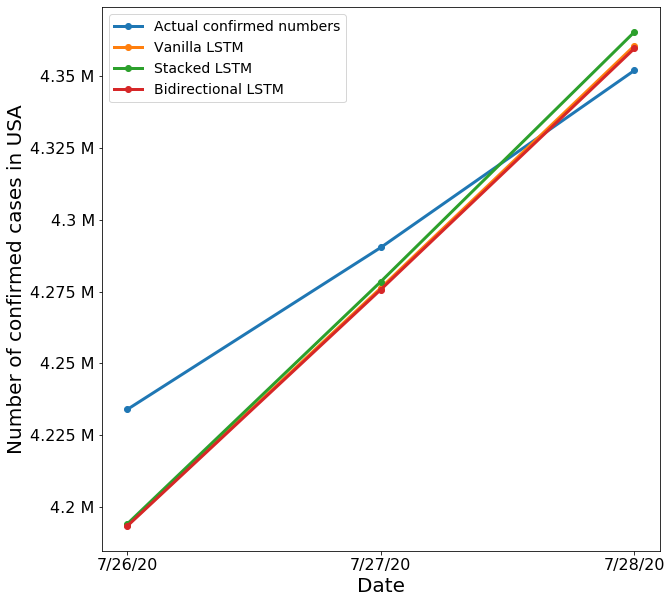

In [13]:
plt.figure(figsize=(10,10))
datesForPlottingList = datesGreaterDaysSinceList[-k:]
groundTruthList = nCasesGreaterDaysSinceList[-k:]


plt.ylabel('Number of confirmed cases in USA', fontsize=20)
plt.plot(datesForPlottingList, groundTruthList, '-o', linewidth=3, label='Actual confirmed numbers');
plt.plot(datesForPlottingList, yPredVanilla[-1], '-o', linewidth=3, label='Vanilla LSTM');
plt.plot(datesForPlottingList, yPredStacked[-1], '-o', linewidth=3, label='Stacked LSTM');
plt.plot(datesForPlottingList, yPredBidirectional[-1], '-o', linewidth=3, label='Bidirectional LSTM');
plt.xlabel('Date', fontsize=20);
plt.legend(fontsize=14);
plt.xticks(fontsize=16);
plt.yticks(fontsize=16);
ax = plt.gca()
ax.yaxis.set_major_formatter(FuncFormatter(y_fmt))
# plt.grid(axis='y')
plt.savefig(os.path.join('Plots_3days_k3', 'predictions_{}.png'.format(countryName)), dpi=400)
plt.savefig(os.path.join('Plots_3days_k3', 'predictions_{}.pdf'.format(countryName)), dpi=400)

In [14]:
RMSE = rootMeanSquaredError(groundTruthList, yPredVanilla)
print('Test RMSE:', RMSE)
RMSE = rootMeanSquaredError(groundTruthList, yPredStacked)
print('Test RMSE:', RMSE)
RMSE = rootMeanSquaredError(groundTruthList, yPredBidirectional)
print('Test RMSE:', RMSE)

Test RMSE: 578154.3936934568
Test RMSE: 573196.3964383497
Test RMSE: 578792.8868623605


In [19]:
RMSE = rootMeanSquaredError(groundTruthList, yPredVanilla[-1])
print('Test RMSE:', RMSE)#Test RMSE: 25181.025045739632

Test RMSE: 25181.025045739632


In [20]:
RMSE = rootMeanSquaredError(groundTruthList, yPredStacked[-1])
print('Test RMSE:', RMSE)#Test RMSE: 25227.194255819122

Test RMSE: 25227.194255819122


In [21]:
RMSE = rootMeanSquaredError(groundTruthList, yPredBidirectional[-1])
print('Test RMSE:', RMSE)#Test RMSE: 25305.00566628732

Test RMSE: 25305.00566628732


In [22]:
groundTruthList
#[4233923, 4290337, 4351997]

[4233923, 4290337, 4351997]

In [23]:
yPredVanilla[-1]
#[4193548.8, 4276257.0, 4360595.0]

[4193548.8, 4276257.0, 4360595.0]

In [24]:
yPredStacked[-1]
#[4194064.2, 4278450.5, 4365384.5]

[4194064.2, 4278450.5, 4365384.5]

In [25]:
yPredBidirectional[-1]
#[4193330.8, 4275682.0, 4359647.5]

[4193330.8, 4275682.0, 4359647.5]